# Project | NLP Automated Customers Reviews

The goal of this project is to automate the processing of customer reviews by comparing traditional machine learning (ML) methods with a deep learning approach (transformers). Additionally, the project aims to use Generative AI to summarize reviews based on ratings and product categories and to create a visualization dashboard.

## **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## **2. Load & Explore Dataset**

In [ ]:
import pandas as pd

# Load dataset
data_path = "1429_1.csv"  

df = pd.read_csv(data_path)

#  Relevant columns
# 'reviews.text', 'reviews.title', 'reviews.rating'

C:\Users\Dan\AppData\Local\Temp\ipykernel_12872\3446327088.py:6: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Average Sentence Length: 30.40 words
Max Length: 1858.00 words
Min Length: 1.00 words


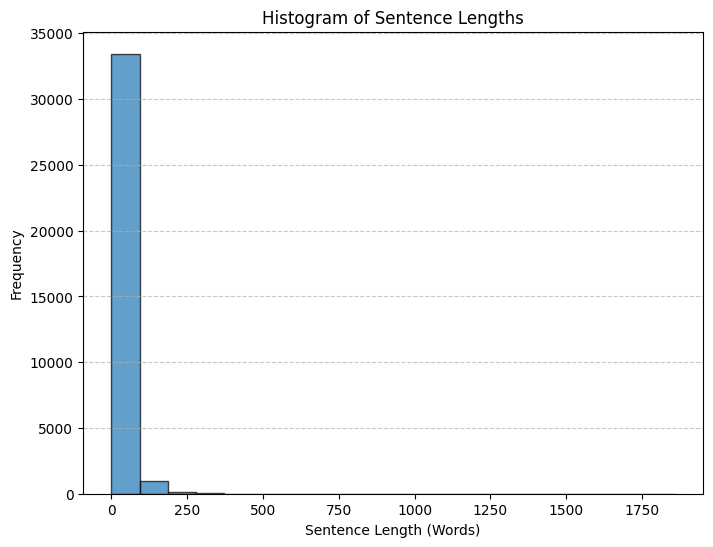

In [11]:
import matplotlib.pyplot as plt


# Calculate sentence lengths (split by spaces)
sentence_lengths = df['reviews.text'].astype(str).apply(lambda x: len(x.split()))

# Compute the average sentence length
avg_length = sentence_lengths.mean()
max_length = sentence_lengths.max()
min_length = sentence_lengths.min()

print(f"Average Sentence Length: {avg_length:.2f} words")
print(f"Max Length: {max_length:.2f} words")
print(f"Min Length: {min_length:.2f} words")


# Generate the histogram
plt.figure(figsize=(8, 6))
plt.hist(sentence_lengths, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Sentence Length (Words)')
plt.ylabel('Frequency')
plt.title('Histogram of Sentence Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [16]:
import unidecode
import spacy
import logging
import time

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Start timer for execution tracking
start_time = time.time()

# Log: Start of preprocessing
logging.info("Starting data preprocessing...")

# Map ratings to sentiment labels
# # 1,2,3 -> 'NEGATIVE'
# 4 -> 'NEUTRAL'
# 5 -> 'POSITIVE'

df['sentiment'] = df['reviews.rating'].map({
    1: 'NEGATIVE',
    2: 'NEGATIVE',
    3: 'NEGATIVE',
    4: 'NEUTRAL',
    5: 'POSITIVE'
})


# Ensure all text values are strings before applying unidecode
logging.info("Converting all text values to string format...")
df['reviews.text'] = df['reviews.text'].astype(str).apply(unidecode.unidecode)


# Log: Loading NLP Model
logging.info("Loading SpaCy model: en_core_web_lg")
nlp = spacy.load('en_core_web_lg')


def preprocess_text(text):
    # process the Text with spacy
    doc = nlp(text.lower())
    # Filter and Lemmatize Tokens
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Log: Applying text preprocessing
logging.info("Applying text preprocessing to all reviews...")
df['clean_text'] = df['reviews.text'].apply(preprocess_text)

# Log: Time taken
end_time = time.time()
logging.info(f"Total execution time: {end_time - start_time:.2f} seconds")


## **4. Feature Extraction**

In [21]:
import logging
import time
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Log: Start of preprocessing
logging.info("Starting data preprocessing and train-test split...")

# Define X (features) and y (target labels)
X = df["clean_text"]  # Features (processed text)
y = df["sentiment"]   # Target labels (POSITIVE, NEUTRAL, NEGATIVE)

# Log: Checking for NaN values
initial_size = len(df)
nan_count = df[['clean_text', 'sentiment']].isna().sum().sum()
logging.info(f"Found {nan_count} missing values. Removing them...")

# Drop rows with NaN values in critical columns
df_clean = df.dropna(subset=["clean_text", "sentiment"])

# Log: Data size after cleaning
final_size = len(df_clean)
logging.info(f"Data cleaned: {initial_size - final_size} rows removed. Remaining rows: {final_size}")

# Update X and y with cleaned data
X = df_clean["clean_text"]
y = df_clean["sentiment"]

# Log: Splitting dataset
logging.info("Splitting data into training (80%) and test (20%) sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Log: Summary of dataset split
logging.info(f"Training set size: {len(X_train)} samples")
logging.info(f"Test set size: {len(X_test)} samples")




2025-01-30 11:44:55,141 - INFO - Starting data preprocessing and train-test split...
2025-01-30 11:44:55,153 - INFO - Found 33 missing values. Removing them...
2025-01-30 11:44:55,168 - INFO - Data cleaned: 33 rows removed. Remaining rows: 34627
2025-01-30 11:44:55,172 - INFO - Splitting data into training (80%) and test (20%) sets...
2025-01-30 11:44:55,290 - INFO - Training set size: 27701 samples
2025-01-30 11:44:55,291 - INFO - Test set size: 6926 samples


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Now apply TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit only on training data
X_test_tfidf = vectorizer.transform(X_test)  # Transform test data using the same vectorizer

## **5. Model Training & Evaluation**

2025-01-30 12:02:53,976 - INFO - Training Logistic Regression model...
2025-01-30 12:02:55,500 - INFO - Model Accuracy: 0.72
2025-01-30 12:02:55,584 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.64      0.25      0.36       462
     NEUTRAL       0.50      0.22      0.30      1708
    POSITIVE       0.75      0.94      0.84      4756

    accuracy                           0.72      6926
   macro avg       0.63      0.47      0.50      6926
weighted avg       0.68      0.72      0.67      6926



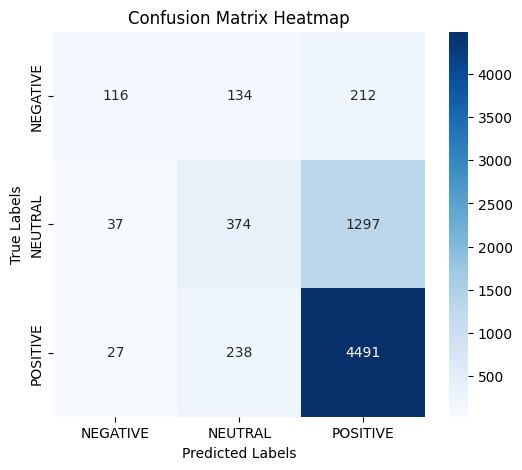

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Logistic Regression model
logging.info("Training Logistic Regression model...")
model = LogisticRegression(max_iter=500)  # Increase iterations for convergence
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
logging.info(f"Model Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, y_pred)
logging.info("\nClassification Report:\n" + report)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ["NEGATIVE", "NEUTRAL", "POSITIVE"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()
